In [3]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import joblib

In [4]:
DATA_SET_PATH = "C:/Users/Anwender/Desktop/MLPC_project"

metadata = pd.read_csv(os.path.join(DATA_SET_PATH, 'metadata.csv'))
files = metadata["filename"]

features_dir = 'audio_features'
labels_dir = 'labels'
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']


def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        votes = np.array(frame_labels)
        vote_sum = np.sum(votes)
        # Majority vote (≥ 50%)
        __y.append(int(vote_sum >= len(votes) / 2))
    return __y

def read_files(file_names, num_to_read=1000):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names[:num_to_read]: #we are not loading the entire dataset due to processing time
        if not os.path.exists(os.path.join(DATA_SET_PATH, features_dir , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(DATA_SET_PATH, features_dir , f.split('.')[0] + '.npz'))["embeddings"]
        X_train.append(features)
        y = np.load(os.path.join(DATA_SET_PATH, labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(_y)
    X_train = np.concatenate(X_train)
    
    return X_train, convert_y_dict_to_array(Y_train, categories)

def convert_y_dict_to_array(y_dict, categories):
    y_array = np.zeros((len(y_dict[categories[0]]), len(categories)), dtype=int)
    for i, c in enumerate(categories):
        y_array[:, i] = y_dict[c]
    return y_array

nf = len(files)
sampled_files = files.sample(nf, random_state=0)

# train set 70%, val set 20%, test set 10% --> could also val, test = 15 %
train_files = sampled_files[:int(nf*0.7)]
val_files = sampled_files[int(nf*0.7):int(nf*0.9)]
test_files = sampled_files[int(nf*0.9):]

In [3]:
file_fraction = 0.1
X_train, Y_train = read_files(train_files, num_to_read=int(len(train_files)*file_fraction))
X_val, Y_val = read_files(val_files, num_to_read=int(len(val_files)*file_fraction))
X_test, Y_test = read_files(test_files, num_to_read=int(len(test_files)*file_fraction))

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
del X_train, X_val, X_test

# reduce dimensionality to reduce training time
pca = PCA(n_components=200, random_state=0)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_val_reduced = pca.transform(X_val_scaled)
X_test_reduced = pca.transform(X_test_scaled)
del X_train_scaled, X_test_scaled

# reduce size for testing
x_train, y_train = X_train_reduced[:50000], Y_train[:50000]
x_val, y_val = X_val_reduced[:5000], Y_val[:5000]
#x_train, y_train = X_train_scaled, Y_train
#x_val, y_val = X_val_scaled, Y_val

# TODO maybe stratify?

### Notably, the MultiLabelBaseline classifier in data-split_evaluation.ipynb is very bad, averaging the f1 scores leads to a misleadingly high score. A better baseline is needed.

# Experiments

## KNN

c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=1:
    val macro f1 score: 0.2046
    val weighted f1 score: 0.5164
    val sampled f1 score: 0.5302


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=5:
    val macro f1 score: 0.1863
    val weighted f1 score: 0.4907
    val sampled f1 score: 0.5091


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=10:
    val macro f1 score: 0.1847
    val weighted f1 score: 0.4869
    val sampled f1 score: 0.5021


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=20:
    val macro f1 score: 0.1859
    val weighted f1 score: 0.4897
    val sampled f1 score: 0.5039


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


knn with n=100:
    val macro f1 score: 0.1776
    val weighted f1 score: 0.4849
    val sampled f1 score: 0.4906


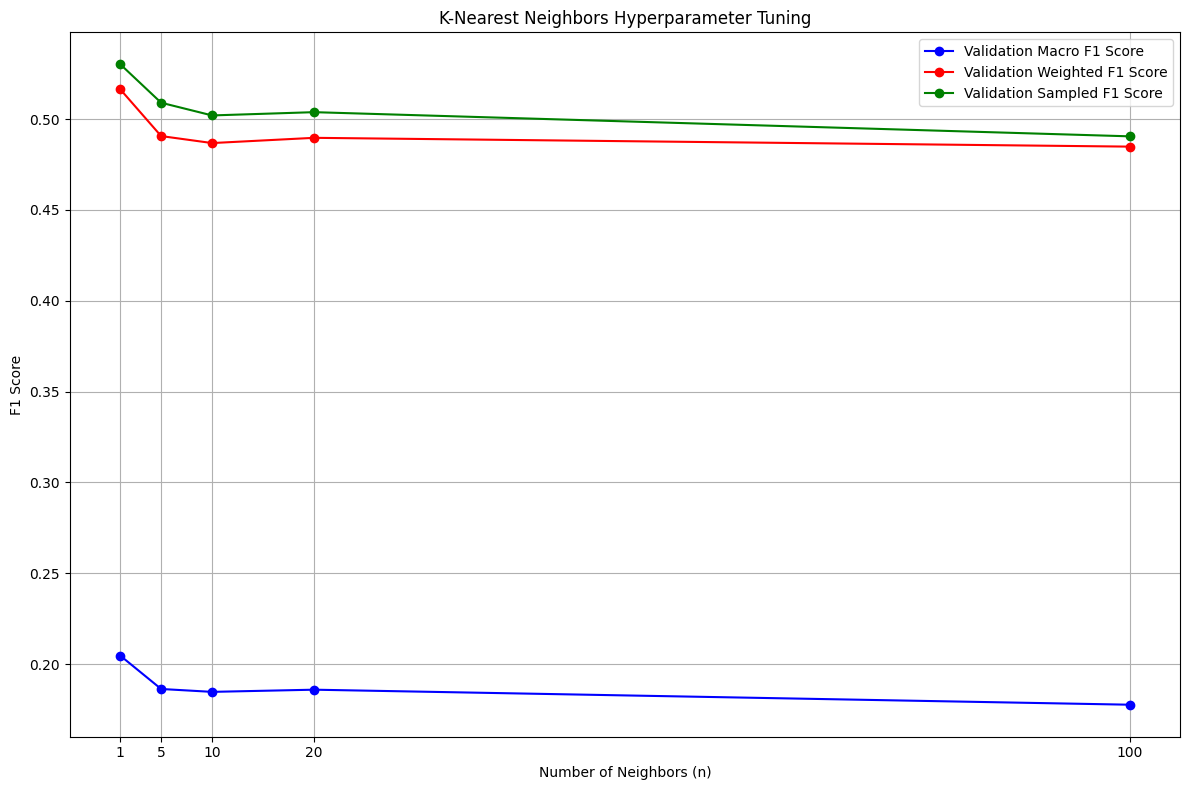

In [ ]:
n_neighbors_list = [1, 5, 10, 20, 100] # n=1 heavily overfits, train f1=1.0
knn_val_macro_scores = []
knn_val_weighted_scores = []
knn_val_sampled_scores = []

for n in n_neighbors_list:
    knn_model_n = OneVsRestClassifier(KNeighborsClassifier(n))
    knn_model_n.fit(x_train, y_train)
    print(f'knn with n={n}:')
    
    knn_val_pred = knn_model_n.predict(x_val)
    knn_val_f1_m = f1_score(y_val, knn_val_pred, average='macro', zero_division=0)
    knn_val_macro_scores.append(knn_val_f1_m)
    print(f'    val macro f1 score: {knn_val_f1_m:.4f}')

    knn_val_f1_w = f1_score(y_val, knn_val_pred, average='weighted', zero_division=0)
    knn_val_weighted_scores.append(knn_val_f1_w)
    print(f'    val weighted f1 score: {knn_val_f1_w:.4f}')

    knn_val_f1_s = f1_score(y_val, knn_val_pred, average='samples', zero_division=0)
    knn_val_sampled_scores.append(knn_val_f1_s)
    print(f'    val sampled f1 score: {knn_val_f1_s:.4f}')
    
    # knn_train_pred = knn_model_n.predict(x_train)
    # knn_train_f1 = f1_score(y_train, knn_train_pred, average='macro')
    # print(f'    train macro f1 score: {knn_train_f1}')

plt.figure(figsize=(12, 8))
plt.plot(n_neighbors_list, knn_val_macro_scores, marker='o', label='Validation Macro F1 Score', color='blue')
plt.plot(n_neighbors_list, knn_val_weighted_scores, marker='o', label='Validation Weighted F1 Score', color='red')
plt.plot(n_neighbors_list, knn_val_sampled_scores, marker='o', label='Validation Sampled F1 Score', color='green')
plt.xlabel('Number of Neighbors (n)')
plt.ylabel('F1 Score')
plt.title('K-Nearest Neighbors Hyperparameter Tuning')
plt.xticks(n_neighbors_list)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('knn_hyperparameter_tuning.png')

## Decision Trees

c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


Decision Tree with max_depth=1:
    val macro f1 score: 0.0581
    val weighted f1 score: 0.2152
    val sampled f1 score: 0.2205


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


Decision Tree with max_depth=5:
    val macro f1 score: 0.0995
    val weighted f1 score: 0.3356
    val sampled f1 score: 0.3070


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


Decision Tree with max_depth=10:
    val macro f1 score: 0.1071
    val weighted f1 score: 0.3492
    val sampled f1 score: 0.3067


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


Decision Tree with max_depth=20:
    val macro f1 score: 0.1071
    val weighted f1 score: 0.3492
    val sampled f1 score: 0.3067


c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Anwender\anaconda3\envs\handsonAI\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(


Decision Tree with max_depth=None:
    val macro f1 score: 0.1071
    val weighted f1 score: 0.3492
    val sampled f1 score: 0.3067


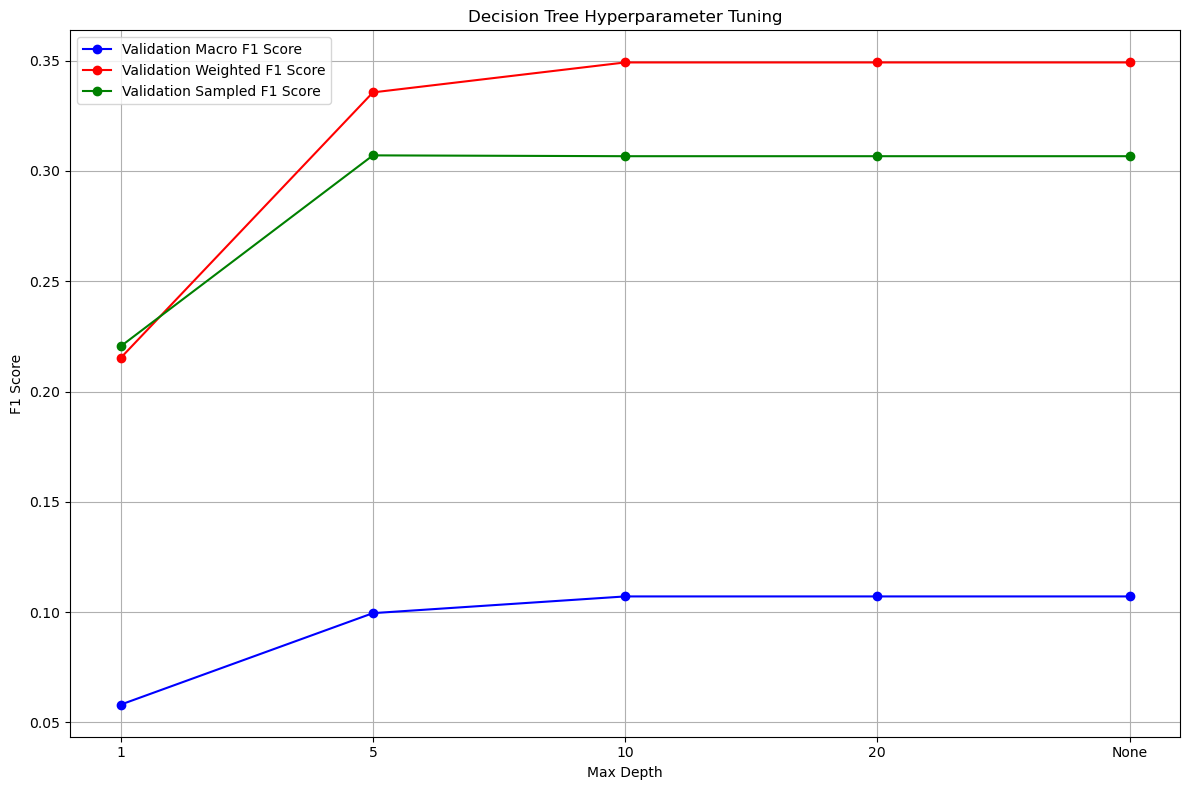

In [ ]:
max_depth_list = [1, 5, 10, 20, None]  # None means no max depth (full tree)
dt_val_macro_scores = []
dt_val_weighted_scores = []
dt_val_sampled_scores = []

for depth in max_depth_list:
    dt_model = OneVsRestClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_split=1000, min_samples_leaf=100, random_state=0))
    dt_model.fit(x_train, y_train)
    print(f'Decision Tree with max_depth={depth}:')
    
    dt_val_pred = dt_model.predict(x_val)
    dt_val_f1_m = f1_score(y_val, dt_val_pred, average='macro', zero_division=0)
    dt_val_macro_scores.append(dt_val_f1_m)
    print(f'    val macro f1 score: {dt_val_f1_m:.4f}')

    dt_val_f1_w = f1_score(y_val, dt_val_pred, average='weighted', zero_division=0)
    dt_val_weighted_scores.append(dt_val_f1_w)
    print(f'    val weighted f1 score: {dt_val_f1_w:.4f}')

    dt_val_f1_s = f1_score(y_val, dt_val_pred, average='samples', zero_division=0)
    dt_val_sampled_scores.append(dt_val_f1_s)
    print(f'    val sampled f1 score: {dt_val_f1_s:.4f}')

plt.figure(figsize=(12, 8))
plt.plot([str(d) for d in max_depth_list], dt_val_macro_scores, marker='o', label='Validation Macro F1 Score', color='blue')
plt.plot([str(d) for d in max_depth_list], dt_val_weighted_scores, marker='o', label='Validation Weighted F1 Score', color='red')
plt.plot([str(d) for d in max_depth_list], dt_val_sampled_scores, marker='o', label='Validation Sampled F1 Score', color='green')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.title('Decision Tree Hyperparameter Tuning')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('dt_hyperparameter_tuning.png')

## SVM

In [ ]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='sklearn')

kernel_list = ['linear', 'rbf']
C_list = [0.1, 1, 10]
# gamma_list = ['scale', 'auto'] does not make a difference
svm_val_macro_scores = {'linear': [], 'rbf': []}
svm_val_weighted_scores = {'linear': [], 'rbf': []}
svm_val_sampled_scores = {'linear': [], 'rbf': []}

for kernel in kernel_list:
    for C in C_list:
        # svm_model_n = OneVsRestClassifier(SVC(kernel=kernel, C=C, gamma='scale', max_iter=1000)) if kernel != 'linear' else OneVsRestClassifier(LinearSVC(C=C, max_iter=1000))
        svm_model_n = OneVsRestClassifier(SVC(kernel=kernel, C=C, gamma='scale', max_iter=1000))
        svm_model_n.fit(x_train, y_train)
        print(f'SVM with kernel={kernel}, C={C}:')
        
        svm_val_pred = svm_model_n.predict(x_val)
        svm_val_f1 = f1_score(y_val, svm_val_pred, average='macro', zero_division=0)
        svm_val_macro_scores[kernel].append(svm_val_f1)
        print(f'    val macro f1 score: {svm_val_f1:.4f}')
        
        svm_val_f1_w = f1_score(y_val, svm_val_pred, average='weighted', zero_division=0)
        svm_val_weighted_scores[kernel].append(svm_val_f1_w)
        print(f'    val weighted f1 score: {svm_val_f1_w:.4f}')

        svm_val_f1_s = f1_score(y_val, svm_val_pred, average='samples', zero_division=0)
        svm_val_sampled_scores[kernel].append(svm_val_f1_s)
        print(f'    val sampled f1 score: {svm_val_f1_s:.4f}')

svm_results = []
for kernel in kernel_list:
    for i, C in enumerate(C_list):
        svm_results.append({
            'kernel': kernel,
            'C': C,
            'val_macro_f1': svm_val_macro_scores[kernel][i],
            'val_weighted_f1': svm_val_weighted_scores[kernel][i],
            'val_sampled_f1': svm_val_sampled_scores[kernel][i]
        })
svm_results_sorted = sorted(svm_results, key=lambda r: r['val_weighted_f1'] + r['val_macro_f1'] + r['val_sampled_f1'], reverse=True)
labels = [f'kernel={r["kernel"]}, C={r["C"]}' for r in svm_results_sorted]
macro_f1_scores = [r['val_macro_f1'] for r in svm_results_sorted]
weighted_f1_scores = [r['val_weighted_f1'] - r['val_macro_f1'] for r in svm_results_sorted]
sampled_f1_scores = [r['val_sampled_f1'] - r['val_weighted_f1'] - r['val_macro_f1'] for r in svm_results_sorted]

plt.figure(figsize=(12, 8))
x = range(len(labels))
plt.bar(x, macro_f1_scores, label='Macro F1 Score', color='blue')
plt.bar(x, weighted_f1_scores, bottom=macro_f1_scores, label='Weighted F1 Score', color='red')
plt.bar(x, sampled_f1_scores, bottom=np.array(macro_f1_scores) + np.array(weighted_f1_scores), label='Sampled F1 Score', color='green')
plt.xticks(x, labels, rotation=90, fontsize=8)
plt.ylabel('F1 Score')
plt.title('SVM Hyperparameter Tuning')
plt.legend()
plt.tight_layout()
plt.savefig('svm_hyperparameter_tuning.png')

SVM with kernel=linear, C=0.1:
    val macro f1 score: 0.1914
    val weighted f1 score: 0.4861
    val sampled f1 score: 0.4636


## NN

c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(128,), activation=relu, alpha=0.0001:
    val macro f1 score: 0.1623
    val weighted f1 score: 0.4336
    val sampled f1 score: 0.4415


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(128,), activation=relu, alpha=0.001:
    val macro f1 score: 0.1672
    val weighted f1 score: 0.4343
    val sampled f1 score: 0.4348


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(128,), activation=relu, alpha=0.01:
    val macro f1 score: 0.1660
    val weighted f1 score: 0.4370
    val sampled f1 score: 0.4323


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(128,), activation=tanh, alpha=0.0001:
    val macro f1 score: 0.1870
    val weighted f1 score: 0.5135
    val sampled f1 score: 0.5290


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(128,), activation=tanh, alpha=0.001:
    val macro f1 score: 0.1952
    val weighted f1 score: 0.5168
    val sampled f1 score: 0.5347


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(128,), activation=tanh, alpha=0.01:
    val macro f1 score: 0.2287
    val weighted f1 score: 0.5459
    val sampled f1 score: 0.5610


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(256, 128), activation=relu, alpha=0.0001:
    val macro f1 score: 0.1473
    val weighted f1 score: 0.4017
    val sampled f1 score: 0.3955


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(256, 128), activation=relu, alpha=0.001:
    val macro f1 score: 0.1751
    val weighted f1 score: 0.4516
    val sampled f1 score: 0.4430
Neural Network with hidden layers=(256, 128), activation=relu, alpha=0.01:
    val macro f1 score: 0.1649
    val weighted f1 score: 0.4164
    val sampled f1 score: 0.4038


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(256, 128), activation=tanh, alpha=0.0001:
    val macro f1 score: 0.2050
    val weighted f1 score: 0.5445
    val sampled f1 score: 0.5158


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(256, 128), activation=tanh, alpha=0.001:
    val macro f1 score: 0.2052
    val weighted f1 score: 0.5404
    val sampled f1 score: 0.5229
Neural Network with hidden layers=(256, 128), activation=tanh, alpha=0.01:
    val macro f1 score: 0.2048
    val weighted f1 score: 0.5190
    val sampled f1 score: 0.5235


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(512, 256), activation=relu, alpha=0.0001:
    val macro f1 score: 0.1723
    val weighted f1 score: 0.4569
    val sampled f1 score: 0.4552
Neural Network with hidden layers=(512, 256), activation=relu, alpha=0.001:
    val macro f1 score: 0.1823
    val weighted f1 score: 0.4702
    val sampled f1 score: 0.4637


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(512, 256), activation=relu, alpha=0.01:
    val macro f1 score: 0.1999
    val weighted f1 score: 0.5061
    val sampled f1 score: 0.5030


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network with hidden layers=(512, 256), activation=tanh, alpha=0.0001:
    val macro f1 score: 0.2015
    val weighted f1 score: 0.5119
    val sampled f1 score: 0.5209
Neural Network with hidden layers=(512, 256), activation=tanh, alpha=0.001:
    val macro f1 score: 0.2169
    val weighted f1 score: 0.5492
    val sampled f1 score: 0.5380
Neural Network with hidden layers=(512, 256), activation=tanh, alpha=0.01:
    val macro f1 score: 0.2354
    val weighted f1 score: 0.5702
    val sampled f1 score: 0.5561


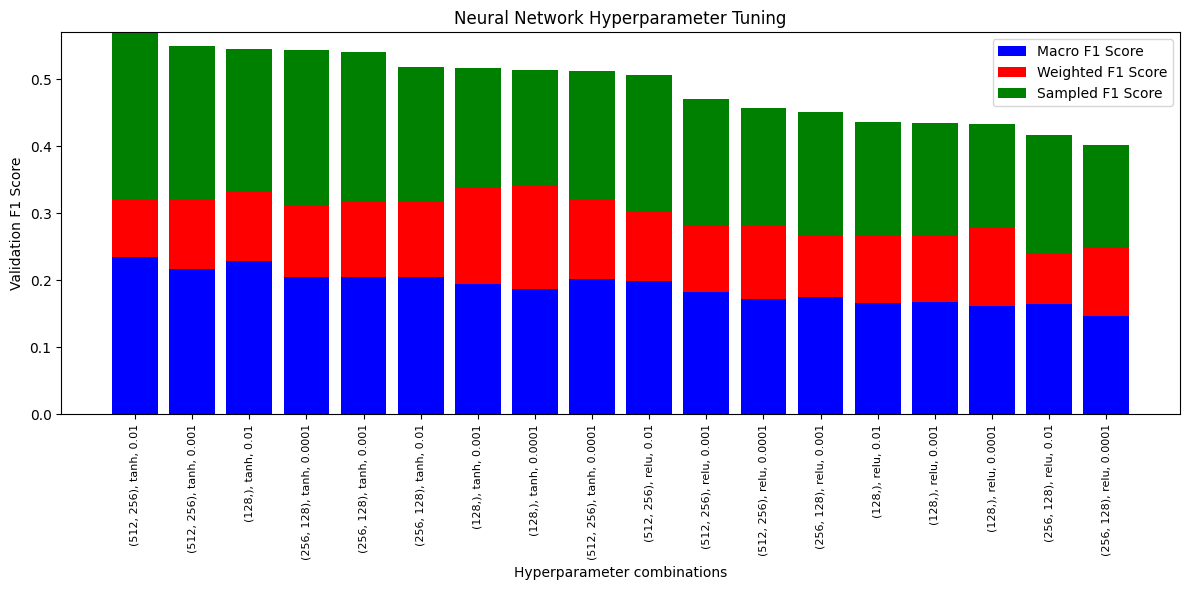

<Figure size 640x480 with 0 Axes>

In [ ]:
hidden_layers_list = [(128, ), (256, 128), (512, 256)] # (512, 256, 128) heavily overfits
activation_list = ['relu', 'tanh']
alpha_list = [0.0001, 0.001, 0.01]

results = []
for hidden_layers in hidden_layers_list:
    for activation in activation_list:
        for alpha in alpha_list:
            mlp_model = MLPClassifier(
                hidden_layer_sizes=hidden_layers,
                activation=activation,
                alpha=alpha,
                solver='adam',
                max_iter=100,
                random_state=0,
                verbose=False
            )

            mlp_model.fit(x_train, y_train)
            mlp_val_pred = mlp_model.predict(x_val)
            mlp_val_f1_m = f1_score(y_val, mlp_val_pred, average='macro', zero_division=0)
            mlp_val_f1_w = f1_score(y_val, mlp_val_pred, average='weighted', zero_division=0)
            mlp_val_f1_s = f1_score(y_val, mlp_val_pred, average='samples', zero_division=0)

            print(f'Neural Network with hidden layers={hidden_layers}, activation={activation}, alpha={alpha}:')
            print(f'    val macro f1 score: {mlp_val_f1_m:.4f}')
            print(f'    val weighted f1 score: {mlp_val_f1_w:.4f}')
            print(f'    val sampled f1 score: {mlp_val_f1_s:.4f}')
            results.append({
                'hidden_layers': hidden_layers,
                'activation': activation,
                'alpha': alpha,
                'val_macro_f1': mlp_val_f1_m,
                'val_weighted_f1': mlp_val_f1_w,
                'val_sampled_f1': mlp_val_f1_s
            })

n_results_sorted = sorted(results, key=lambda x: x['val_weighted_f1'] + x['val_weighted_f1'], reverse=True)
labels = [f"{r['hidden_layers']}, {r['activation']}, {r['alpha']}" for r in n_results_sorted]
macro_f1_scores = [r['val_macro_f1'] for r in n_results_sorted]
weighted_f1_scores = [r['val_weighted_f1'] - r['val_macro_f1'] for r in n_results_sorted]  # stacked above macro
sampled_f1_scores = [r['val_sampled_f1'] - r['val_weighted_f1'] - r['val_macro_f1'] for r in n_results_sorted]
plt.figure(figsize=(12, 6))
x = range(len(labels))
plt.bar(x, macro_f1_scores, label='Macro F1 Score', color='blue')
plt.bar(x, weighted_f1_scores, bottom=macro_f1_scores, label='Weighted F1 Score', color='red')
plt.bar(x, sampled_f1_scores, bottom=np.array(macro_f1_scores) + np.array(weighted_f1_scores), label='Sampled F1 Score', color='green')
plt.xticks(x, labels, rotation=90, fontsize=8)
plt.xlabel("Hyperparameter combinations")
plt.ylabel("Validation F1 Score")
plt.title("Neural Network Hyperparameter Tuning")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("nn_hyperparameter_tuning.png")

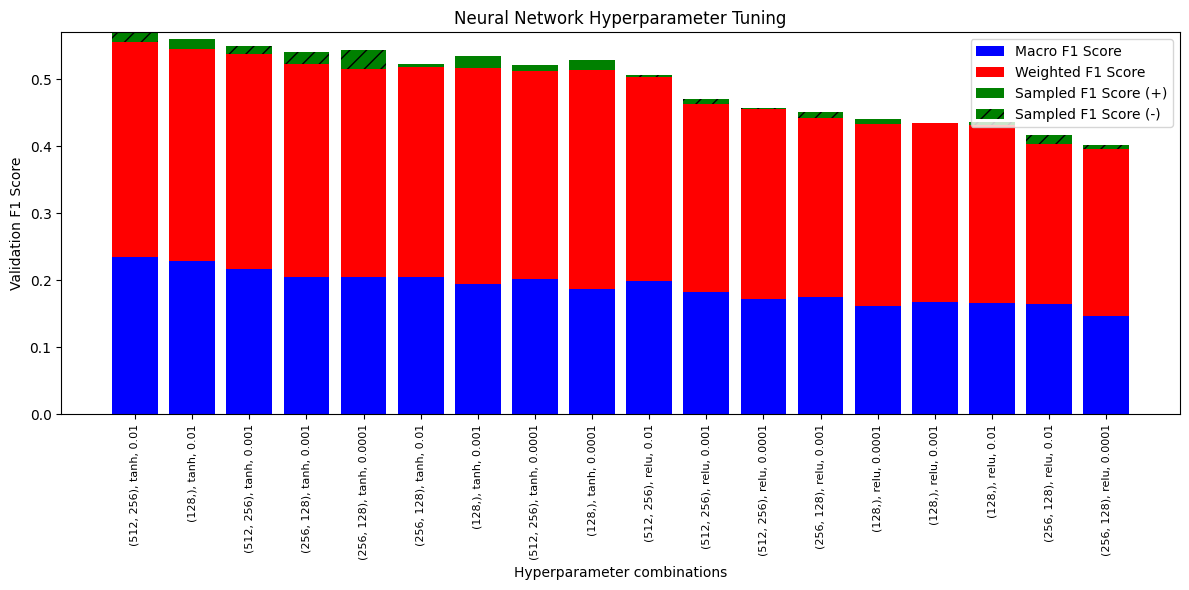

<Figure size 640x480 with 0 Axes>

In [8]:
n_results_sorted = sorted(results, key=lambda x: x['val_weighted_f1'] + x['val_macro_f1'] + x['val_sampled_f1'], reverse=True)

labels = [f"{r['hidden_layers']}, {r['activation']}, {r['alpha']}" for r in n_results_sorted]
macro_f1_scores = np.array([r['val_macro_f1'] for r in n_results_sorted])
weighted_total = np.array([r['val_weighted_f1'] for r in n_results_sorted])
sampled_total = np.array([r['val_sampled_f1'] for r in n_results_sorted])
weighted_f1_scores = weighted_total - macro_f1_scores
sampled_f1_scores = sampled_total - weighted_total

x = np.arange(len(labels))
plt.figure(figsize=(12, 6))
plt.bar(x, macro_f1_scores, label='Macro F1 Score', color='blue')
plt.bar(x, weighted_f1_scores, bottom=macro_f1_scores, label='Weighted F1 Score', color='red')

bottom_sampled = macro_f1_scores + weighted_f1_scores
sampled_positive = np.maximum(sampled_f1_scores, 0)
sampled_negative = np.minimum(sampled_f1_scores, 0)

plt.bar(x, sampled_positive, bottom=bottom_sampled, label='Sampled F1 Score (+)', color='green')
plt.bar(x, sampled_negative, bottom=bottom_sampled, label='Sampled F1 Score (-)', color='green', hatch='//')

plt.xticks(x, labels, rotation=90, fontsize=8)
plt.xlabel("Hyperparameter combinations")
plt.ylabel("Validation F1 Score")
plt.title("Neural Network Hyperparameter Tuning")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("nn_hyperparameter_tuning.png")

## evaluate models with best parameters on test set

In [5]:
print('reading data...')
file_fraction = 1
X_train, Y_train = read_files(train_files, num_to_read=int(len(train_files)*file_fraction))
X_val, Y_val = read_files(val_files, num_to_read=int(len(val_files)*file_fraction))
X_test, Y_test = read_files(test_files, num_to_read=int(len(test_files)*file_fraction))

print('scaling data...')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TODO still use PCA?
print('performing PCA...')
pca = PCA(n_components=200, random_state=0)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)
del X_train_scaled, X_test_scaled

del X_train, X_test # free memory

reading data...
scaling data...
performing PCA...


In [11]:
print('knn with n=1:')
knn_best_model = OneVsRestClassifier(KNeighborsClassifier(1))
print(f'    training...')
knn_best_model.fit(X_train_reduced, Y_train)
print(f'    evaluating...')
knn_test_pred = knn_best_model.predict(X_test_reduced)
knn_test_m_f1 = f1_score(Y_test, knn_test_pred, average='macro')
knn_test_w_f1 = f1_score(Y_test, knn_test_pred, average='weighted')
knn_test_s_f1 = f1_score(Y_test, knn_test_pred, average='samples')
print(f"    knn test macro f1 score: {knn_test_m_f1:.4f}")
print(f"    knn test weighted f1 score: {knn_test_w_f1:.4f}")
print(f"    knn test sampled f1 score: {knn_test_s_f1:.4f}")
#knn_test_balanced_acc = sklearn.metrics.balanced_accuracy_score(Y_test, knn_test_pred)
#knn_test_acc = accuracy_score(Y_test, knn_test_pred)
#print(f"    knn test accuracy score: {knn_test_acc:.4f}")
#print(f"    knn test balanced accuracy score: {knn_test_balanced_acc:.4f}")
joblib.dump(knn_best_model, 'knn_best_model.pkl')

knn with n=1:
    training...
    evaluating...


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this beh

    knn test macro f1 score: 0.4504
    knn test weighted f1 score: 0.5115
    knn test sampled f1 score: 0.4944


['knn_best_model.pkl']

In [12]:
print('decision tree with max_depth=10:') # change to best depth
dt_best_model = sklearn.tree.DecisionTreeClassifier(max_depth=10)
print(f'    training...')
dt_best_model.fit(X_train_reduced, Y_train)
print(f'    evaluating...')
dt_test_pred = dt_best_model.predict(X_test_reduced)
dt_test_m_f1 = f1_score(Y_test, dt_test_pred, average='macro')
dt_test_w_f1 = f1_score(Y_test, dt_test_pred, average='weighted')
dt_test_s_f1 = f1_score(Y_test, dt_test_pred, average='samples')
print(f"    dt test macro f1 score: {dt_test_m_f1:.4f}")
print(f"    dt test weighted f1 score: {dt_test_w_f1:.4f}")
print(f"    dt test sampled f1 score: {dt_test_s_f1:.4f}")
#dt_test_balanced_acc = sklearn.metrics.balanced_accuracy_score(Y_test, dt_test_pred)
#dt_test_acc = accuracy_score(Y_test, dt_test_pred)
#print(f"    dt test accuracy score: {dt_test_acc:.4f}")
#print(f"    dt test balanced accuracy score: {dt_test_balanced_acc:.4f}")
joblib.dump(dt_best_model, 'dt_best_model.pkl')

decision tree with max_depth=10:
    training...
    evaluating...


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


    dt test macro f1 score: 0.1803
    dt test weighted f1 score: 0.3011
    dt test sampled f1 score: 0.2476


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['dt_best_model.pkl']

In [ ]:
print('svm linear with c=0.1:')
svm_best_model = sklearn.svm.LinearSVC(C=0.1, max_iter=1000)
print('     training svm...')
svm_best_model.fit(X_train_reduced, Y_train)
print('     evaluating svm...')
svm_test_pred = svm_best_model.predict(X_test_reduced)
svm_test_m_f1 = f1_score(Y_test, svm_test_pred, average='macro')
svm_test_w_f1 = f1_score(Y_test, svm_test_pred, average='weighted')
print(f"    svm test macro f1 score: {svm_test_m_f1:.4f}")
print(f"    svm test weighted f1 score: {svm_test_w_f1:.4f}")
svm_test_balanced_acc = sklearn.metrics.balanced_accuracy_score(Y_test, svm_test_pred)
svm_test_acc = accuracy_score(Y_test, svm_test_pred)
print(f"    knn test accuracy score: {svm_test_acc:.4f}")
print(f"    knn test balanced accuracy score: {svm_test_balanced_acc:.4f}")

svm linear with c=0.1:
     training svm...


In [4]:
print('nn with hidden layers (512, 256), activation tanh, alpha 0.01:')
nn_best_model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(512, 256), activation='tanh', alpha=0.01, solver='adam', max_iter=100, random_state=0, verbose=False)
print(f'    training nn...')
nn_best_model.fit(X_train_reduced, Y_train)
print(f'    evaluating nn...')
nn_test_pred = nn_best_model.predict(X_test_reduced)
nn_test_m_f1 = f1_score(Y_test, nn_test_pred, average='macro', zero_division=0)
nn_test_w_f1 = f1_score(Y_test, nn_test_pred, average='weighted', zero_division=0)
nn_test_s_f1 = f1_score(Y_test, nn_test_pred, average='samples', zero_division=0)
print(f"    nn test macro f1 score: {nn_test_m_f1:.4f}")
print(f"    nn test weighted f1 score: {nn_test_w_f1:.4f}")
print(f"    nn test sampled f1 score: {nn_test_s_f1:.4f}")
joblib.dump(nn_best_model, 'nn_best_model.pkl')
# nn_test_balanced_acc = sklearn.metrics.balanced_accuracy_score(Y_test, nn_test_pred)
# nn_test_acc = accuracy_score(Y_test, nn_test_pred)
# print(f"     nn test accuracy score: {nn_test_acc:.4f}")
# print(f"     nn test balanced accuracy score: {nn_test_balanced_acc:.4f}")

nn with hidden layers (512, 256), activation tanh, alpha 0.01:
    training nn...


c:\Users\Anwender\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


    evaluating nn...
    nn test macro f1 score: 0.5334
    nn test weighted f1 score: 0.5861
    nn test sampled f1 score: 0.5229


['nn_best_model.pkl']

In [13]:
from sklearn.metrics import balanced_accuracy_score

test_model = joblib.load('nn_best_model.pkl')
test_predict = test_model.predict(X_test_reduced)
nn_test_acc = accuracy_score(Y_test, test_predict)
print(f"exact match accuracy: {nn_test_acc:.4f}")

n_labels = Y_test.shape[1]
balanced_accuracies = []
accuracies = []

for i in range(n_labels):
    bacc = balanced_accuracy_score(Y_test[:, i], test_predict[:, i])
    acc = accuracy_score(Y_test[:, i], test_predict[:, i])
    accuracies.append(acc)
    balanced_accuracies.append(bacc)

average_balanced_accuracy = sum(balanced_accuracies) / n_labels
print(f"Mean Balanced Accuracy (per-label): {average_balanced_accuracy:.4f}")
average_accuracy = sum(accuracies) / n_labels
print(f"Mean Accuracy (per-label): {average_accuracy:.4f}")

exact match accuracy: 0.4494
Mean Balanced Accuracy (per-label): 0.7289
Mean Accuracy (per-label): 0.9848
